### IS 584 Assignment 1

#### Step 1: Data Exploration and Preprocessing

##### Load and Overview Dataset

In [1]:
import pandas as pd
import json

with open("ICLR.jsonl", "r", encoding="utf-8") as f:
    data = json.load(f)
df = pd.DataFrame(data)
df.head()

,id,conference,decision,url,hasContent,hasReview,title,authors,reviews,metaReview
0,ICLR_2020_1000,ICLR,Reject,http://openreview.net/pdf/cb4db66f6ded623b263b...,true,true,Cross-Iteration Batch Normalization,"[Zhuliang Yao, Yue Cao, Shuxin Zheng, Gao Huan...",[{'review': 'The paper tackles the problem of ...,This paper proposes cross-iteration batch norm...
1,ICLR_2020_1001,ICLR,Reject,http://openreview.net/pdf/c19adcee9586624081cf...,true,true,Robust Reinforcement Learning with Wasserstein...,"[Linfang Hou, Liang Pang, Xin Hong, Yanyan Lan...",[{'review': ' This work aims to produce reinfo...,This paper studies the robust reinforcement le...
2,ICLR_2020_1002,ICLR,Reject,http://openreview.net/pdf/c8db792ae0818842b887...,true,true,Simple and Effective Stochastic Neural Networks,"[Tianyuan Yu, Yongxin Yang, Da Li, Timothy Hos...",[{'review': 'This paper presents a simple stoc...,This paper proposes to use stacked layers of G...
3,ICLR_2020_1003,ICLR,Reject,http://openreview.net/pdf/cd2191e3e737ff42e92d...,true,true,Structural Language Models for Any-Code Genera...,"[Uri Alon, Roy Sadaka, Omer Levy, Eran Yahav]",[{'review': 'The paper proposes a model to add...,This paper proposes a new method for code gene...
4,ICLR_2020_1004,ICLR,Reject,http://openreview.net/pdf/0dd7689b495c6dc23bdc...,true,true,"OPTIMAL TRANSPORT, CYCLEGAN, AND PENALIZED LS ...","[Byeongsu Sim, Gyutaek Oh, Sungjun Lim, and Jo...",[{'review': 'The paper presents an interesting...,This paper provides a novel approach for addre...


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4535 entries, 0 to 4534
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          4535 non-null   object
 1   conference  4535 non-null   object
 2   decision    4535 non-null   object
 3   url         4535 non-null   object
 4   hasContent  4535 non-null   object
 5   hasReview   4535 non-null   object
 6   title       4535 non-null   object
 7   authors     4535 non-null   object
 8   reviews     4535 non-null   object
 9   metaReview  4535 non-null   object
dtypes: object(10)
memory usage: 354.4+ KB


In [3]:
# Show shape, columns, and decision label distribution
data_info = {
    "shape": df.shape,
    "columns": df.columns.tolist(),
    "label_distribution": df["decision"].value_counts(),
    "review_length_stats": df["metaReview"].str.split().str.len().describe(),
    "unique_decisions": df["decision"].unique().tolist()
}

for key, value in data_info.items():
    print(f"\n{key.upper()}:\n", value)


SHAPE:
 (4535, 10)

COLUMNS:
 ['id', 'conference', 'decision', 'url', 'hasContent', 'hasReview', 'title', 'authors', 'reviews', 'metaReview']

LABEL_DISTRIBUTION:
 decision
Reject                      2928
Accept (Poster)             1317
Accept (Spotlight)           107
Invite to Workshop Track      89
Accept (Talk)                 47
Accept (Oral)                 47
Name: count, dtype: int64

REVIEW_LENGTH_STATS:
 count    4535.000000
mean      100.829989
std        80.011953
min         0.000000
25%        50.000000
50%        82.000000
75%       129.000000
max       832.000000
Name: metaReview, dtype: float64

UNIQUE_DECISIONS:
 ['Reject', 'Accept (Poster)', 'Accept (Spotlight)', 'Accept (Talk)', 'Accept (Oral)', 'Invite to Workshop Track']


##### Review Length and Label Grouping

In [4]:
df["review_length"] = df["metaReview"].str.split().str.len()
df["grouped_label"] = df["decision"].replace({
    "Accept (Poster)": "Accept (Poster)",
    "Invite to Workshop Track": "Accept (Otherwise)",
    "Accept (Spotlight)": "Accept (Otherwise)",
    "Accept (Talk)": "Accept (Otherwise)",
    "Accept (Oral)": "Accept (Otherwise)",
    "Reject": "Reject"
})
df["grouped_label"].value_counts()

grouped_label
Reject                2928
Accept (Poster)       1317
Accept (Otherwise)     290
Name: count, dtype: int64

In [5]:
df.groupby("decision")["review_length"].describe()

,count,mean,std,min,25%,50%,75%,max
decision,,,,,,,,
Accept (Oral),47.0,88.808511,70.002683,3.0,34.0,88.0,118.0,365.0
Accept (Poster),1317.0,93.320425,73.461685,0.0,46.0,77.0,120.0,832.0
Accept (Spotlight),107.0,79.887850,51.996249,0.0,43.5,71.0,108.5,297.0
Accept (Talk),47.0,85.531915,52.125622,0.0,50.0,84.0,120.0,231.0
Invite to Workshop Track,89.0,105.269663,55.733082,0.0,67.0,90.0,140.0,310.0
Reject,2928.0,105.276639,84.329697,0.0,51.0,86.0,134.0,703.0


This table summarizes how long meta-reviews tend to be in each decision group. We observe that while most decisions have a wide range of lengths, all categories include at least some reviews with 0 words, suggesting missing or uninformative content.

In [6]:
# Now find and display reviews with review_length == 0
zero_length_reviews = df[df["review_length"] == 0]

# Count and show a few examples
zero_length_count = len(zero_length_reviews)
zero_length_count, zero_length_reviews[["decision", "metaReview"]].head(10)

(98,
     decision metaReview
 37    Reject           
 44    Reject           
 67    Reject           
 71    Reject           
 90    Reject           
 100   Reject           
 136   Reject           
 251   Reject           
 268   Reject           
 361   Reject           )

In [7]:
df = df[df["review_length"] > 0].reset_index(drop=True)

##### Visualization: Label Distribution and Review Lengths

/var/folders/zn/vf7dcg9j5yx547py9_y411jw0000gn/T/ipykernel_6101/1160661322.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='grouped_label', data=df, order=df['grouped_label'].value_counts().index, palette='viridis')


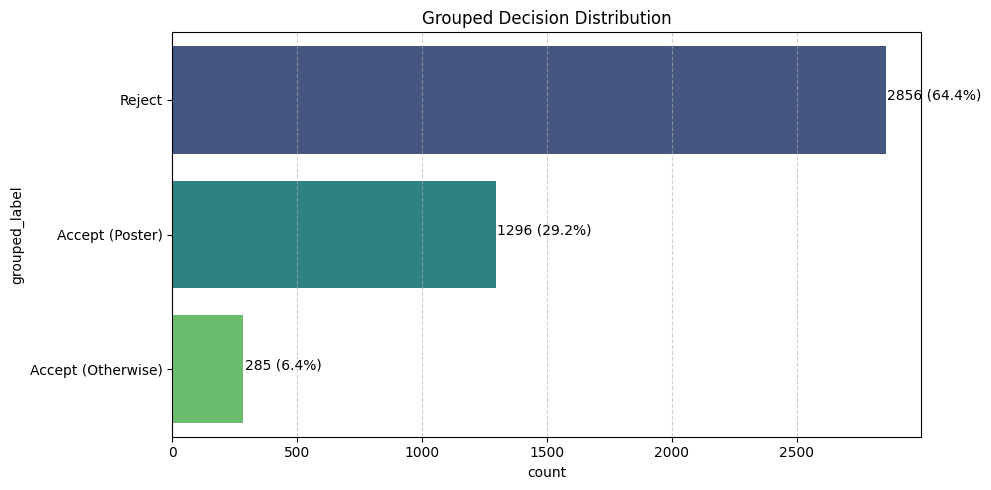

/var/folders/zn/vf7dcg9j5yx547py9_y411jw0000gn/T/ipykernel_6101/1160661322.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='review_length', y='grouped_label', palette='Set2', scale='width')
/var/folders/zn/vf7dcg9j5yx547py9_y411jw0000gn/T/ipykernel_6101/1160661322.py:19: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x='review_length', y='grouped_label', palette='Set2', scale='width')


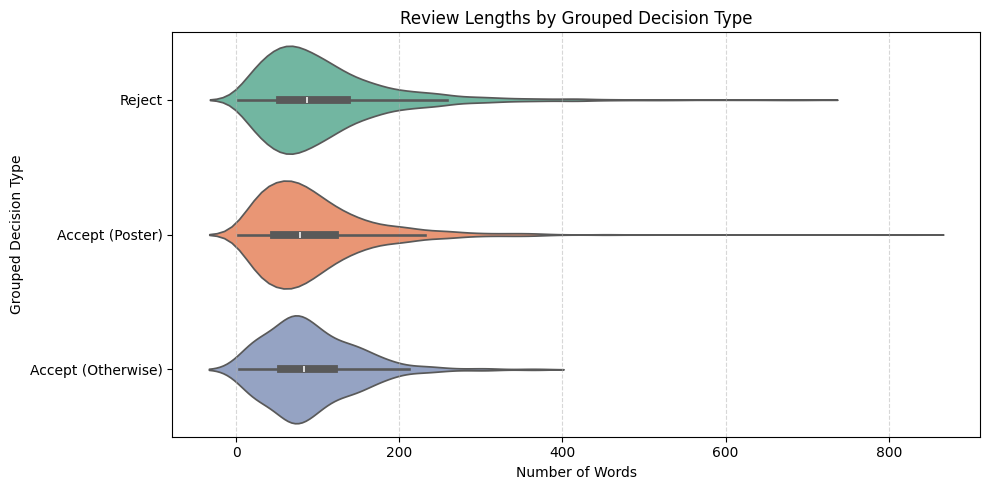

,count,mean,std,min,25%,50%,75%,max
grouped_label,,,,,,,,
Accept (Otherwise),285.0,91.617544,56.349679,3.0,55.00,83.0,120.0,365.0
Accept (Poster),1296.0,94.832562,73.079555,2.0,47.00,78.0,121.0,832.0
Reject,2856.0,107.930672,83.691637,2.0,53.75,87.0,136.0,703.0


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count plot
plt.figure(figsize=(10, 5))
ax = sns.countplot(y='grouped_label', data=df, order=df['grouped_label'].value_counts().index, palette='viridis')
total = len(df)
for p in ax.patches:
    count = int(p.get_width())
    percent = 100 * count / total
    ax.annotate(f'{count} ({percent:.1f}%)', (p.get_width() + 5, p.get_y() + 0.4), fontsize=10)
plt.title('Grouped Decision Distribution')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Violin plot
plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x='review_length', y='grouped_label', palette='Set2', scale='width')
plt.title('Review Lengths by Grouped Decision Type')
plt.xlabel('Number of Words')
plt.ylabel('Grouped Decision Type')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

df.groupby("grouped_label")["review_length"].describe()

Violin plots show the distribution and density of review lengths by decision class. Rejected papers tend to have slightly longer and more variable reviews, possibly due to more critical feedback.

##### Preprocessing Pipeline

In [9]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [10]:
import re
import time
import contractions
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

domain_stopwords = {
    # Common English stopwords
    'the', 'this', 'is', 'in', 'and', 'to', 'has', 'that', 'it', 'of', 'for', 'on', 'with', 'as', 'are', 'at',
    'be', 'by', 'an', 'or', 'if', 'from', 'but', 'not', 'we', 'can', 'have', 'was', 'will', 'our', 'their',
    'which', 'they', 'a', 'i', 'you', 'he', 'she', 'its', 'my', 'your', 'his', 'her', 'some', 'also', 'about',
    'there', 'these', 'would', 'one', 'two', 'other', 'such',

    # Domain-generic filler or metadata
    'paper', 'author', 'review', 'reviewer', 'anonreview', 'iclr',

    # Overused verbs that don’t add class distinction on their own
    'propose', 'study', 'provide', 'use', 'present', 'find', 'write', 'task', 'seem'
}

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def normalize_aliases(text):
    return re.sub(r'\b(R[1-9]|Reviewer\s*\d)\b', 'anonreview', text, flags=re.IGNORECASE)

def clean_and_tokenize(text):
    text = normalize_aliases(text)
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|[^a-z\s]", " ", text)
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tags]
    return list(dict.fromkeys([t for t in lemmatized_tokens if t not in domain_stopwords and len(t) > 2]))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/esrasekerci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/esrasekerci/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/esrasekerci/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/esrasekerci/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


##### Sample Before/After Tokenization

In [11]:
# Re-apply clean_and_tokenize to the DataFrame
start = time.time()
df["tokens"] = df["metaReview"].apply(clean_and_tokenize)
end = time.time()

# Show timing and tokenized examples
avg_time = (end - start) / len(df)
print(f"Applied improved POS-aware preprocessing.")
print(f"Average preprocessing time per review: {avg_time:.4f} seconds")
df[["metaReview", "tokens"]].head(3)

Applied improved POS-aware preprocessing.
Average preprocessing time per review: 0.0019 seconds


,metaReview,tokens
0,This paper proposes cross-iteration batch norm...,"[cross, iteration, batch, normalization, strat..."
1,This paper studies the robust reinforcement le...,"[robust, reinforcement, learn, problem, constr..."
2,This paper proposes to use stacked layers of G...,"[stacked, layer, gaussian, latent, variable, m..."


In [12]:
for i in range(3):
    print(f"\n--- Example {i+1} ---")
    print("Original:", df.iloc[i]["metaReview"][:300])
    print("Tokens:", df.iloc[i]["tokens"][:25], "...")


--- Example 1 ---
Original: This paper proposes cross-iteration batch normalization, which is a strategy for maintaining statistics across iterations to improve the applicability of batch normalization on small batches of data. The reviewers pointed out some strong points but also some weak points about the paper. The paper wa
Tokens: ['cross', 'iteration', 'batch', 'normalization', 'strategy', 'maintain', 'statistic', 'across', 'improve', 'applicability', 'small', 'data', 'point', 'out', 'strong', 'weak', 'judge', 'novel', 'theoretically', 'sound', 'well', 'however', 'doubt', 'regard', 'relevance'] ...

--- Example 2 ---
Original: This paper studies the robust reinforcement learning problem in which the constraint on model uncertainty is captured by the Wasserstein distance. The reviewers expressed concerns regarding novelty with respect to prior work, the presentation or the results, and unconvincing experiments.
Tokens: ['robust', 'reinforcement', 'learn', 'problem', 'constraint', 

##### Token Frequency Distribution and Word Cloud

/var/folders/zn/vf7dcg9j5yx547py9_y411jw0000gn/T/ipykernel_6101/497222635.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_freq_df.head(30), x="count", y="word", palette="coolwarm")


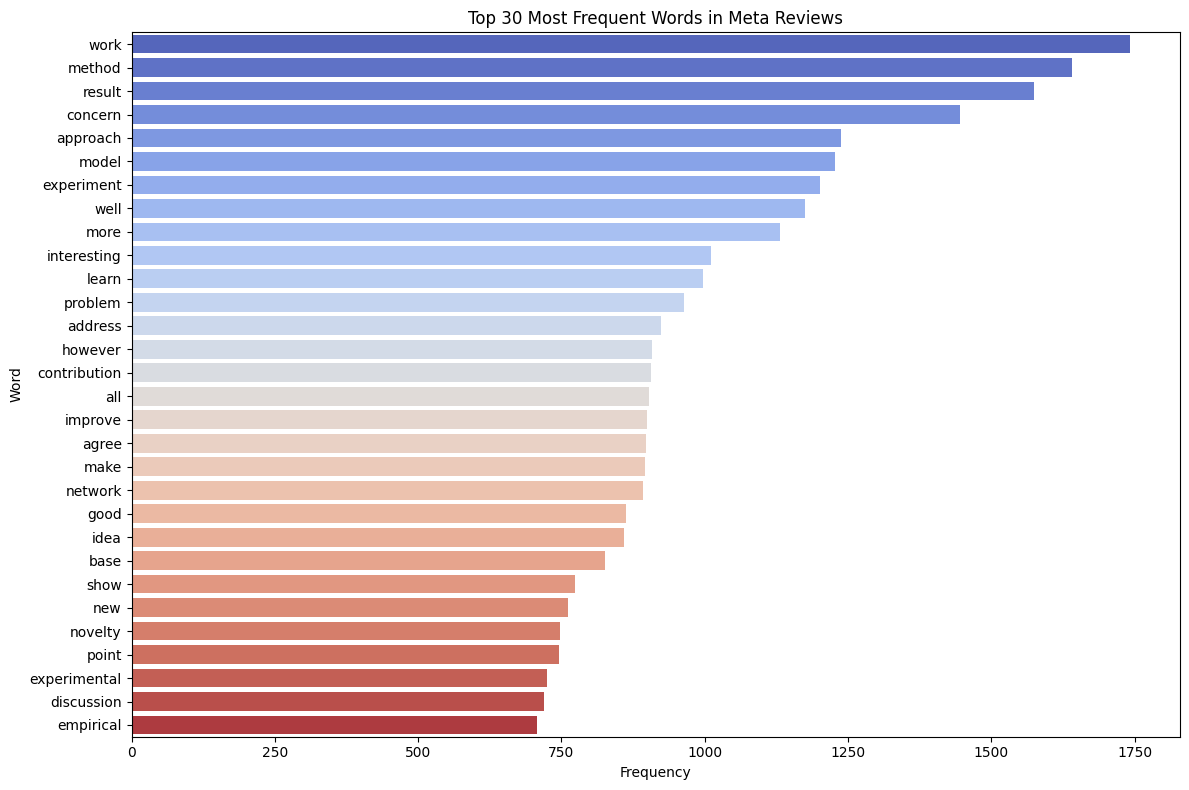

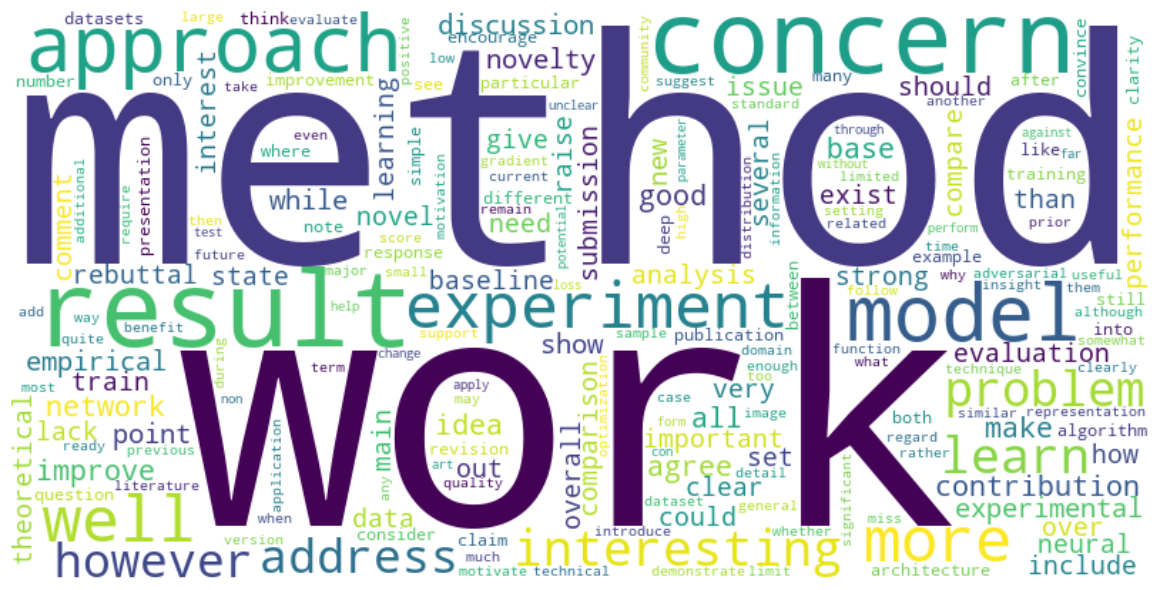

In [13]:
from collections import Counter
from wordcloud import WordCloud

# Token frequency
all_tokens = [t for sublist in df["tokens"] for t in sublist]
word_freq = Counter(all_tokens)
word_freq_df = pd.DataFrame(word_freq.items(), columns=["word", "count"]).sort_values(by="count", ascending=False)

# Top 30 words
plt.figure(figsize=(12, 8))
sns.barplot(data=word_freq_df.head(30), x="count", y="word", palette="coolwarm")
plt.title("Top 30 Most Frequent Words in Meta Reviews")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(14, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

The prevalence of these terms confirms that the reviews primarily assess the methodology and impact of the work, key factors for academic peer reviews. These insights suggest that our NLP model should prioritize recognizing and understanding technical vocabulary and thematic keywords like "novelty," "method," and "result." By focusing on these, the model can better classify reviews according to their primary evaluation criteria.

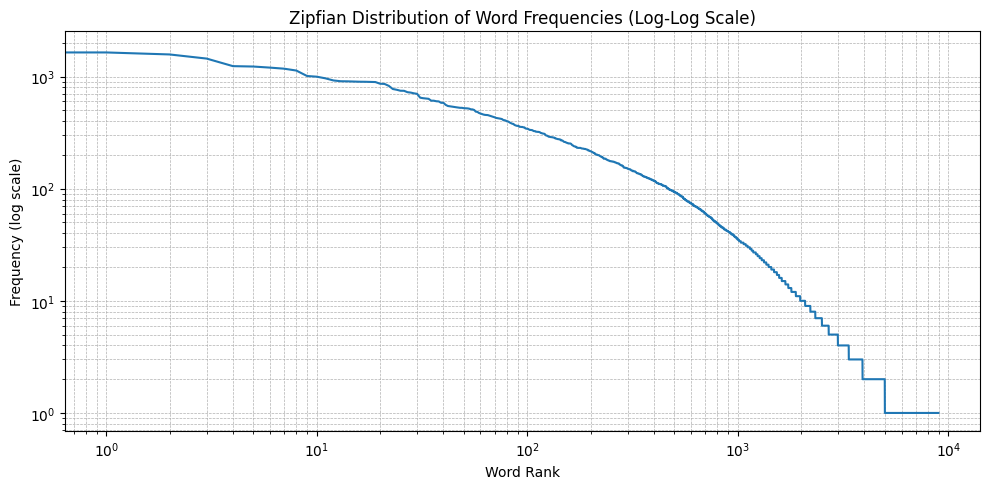

In [14]:
import itertools

# Flatten the list of token lists (from df["tokens"])
words = list(itertools.chain.from_iterable(df["tokens"]))

# Count frequencies
counter = Counter(words)
sorted_by_freq = sorted(counter.items(), key=lambda x: x[1], reverse=True)

# Extract frequencies
frequencies = [freq for word, freq in sorted_by_freq]

# Plot log-log distribution
plt.figure(figsize=(10, 5))
plt.plot(frequencies)
plt.yscale('log')
plt.xscale('log')
plt.title('Zipfian Distribution of Word Frequencies (Log-Log Scale)')
plt.xlabel('Word Rank')
plt.ylabel('Frequency (log scale)')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

This plot confirms that word frequency in the dataset follows Zipf’s Law — a few words occur very frequently, while most occur rarely. This insight supports later vocabulary filtering and truncation.

#### Step 2: Language Modelling
##### 2.1 Initialization

In [15]:
import torch
import torch.nn as nn
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [16]:
def map_decision_class(decision):
    return 0 if "Reject" in decision else 1

df["target"] = df["decision"].apply(map_decision_class)

In [17]:
df['target'].value_counts()

target
0    2856
1    1581
Name: count, dtype: int64

In [18]:
# Define vocabulary
from collections import Counter

token_counter = Counter([t for tokens in df['tokens'] for t in tokens])
vocab = [w for w, c in token_counter.items() if c >= 3]  # Keep words that appear at least 3 times
word2idx = {word: idx for idx, word in enumerate(vocab)}

# Convert to indices and flatten input
df['indexed'] = df['tokens'].apply(lambda toks: [word2idx[token] for token in toks if token in word2idx])
all_inputs = [idx for tokens in df["indexed"] for idx in tokens]
offsets = np.cumsum([0] + [len(seq) for seq in df["indexed"][:-1]])
targets = df["target"].tolist()

X_tensor = torch.tensor(all_inputs, dtype=torch.long)
offsets_tensor = torch.tensor(offsets, dtype=torch.long)
target_tensor = torch.tensor(targets, dtype=torch.long)

In [19]:
class EmbeddingBagDataset(Dataset):
    def __init__(self, X, offsets, y):
        self.X = X
        self.offsets = offsets
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        start = self.offsets[idx]
        end = self.offsets[idx+1] if idx+1 < len(self.offsets) else len(self.X)
        return self.X[start:end], self.offsets[idx], self.y[idx]

In [20]:
# Split the data
idx = np.arange(len(target_tensor))
train_idx, test_idx = train_test_split(idx, test_size=0.15, stratify=target_tensor, random_state=SEED)
train_idx, val_idx = train_test_split(train_idx, test_size=0.1765, stratify=target_tensor[train_idx], random_state=SEED)

In [21]:
train_dataset = EmbeddingBagDataset(X_tensor, offsets_tensor, target_tensor)
val_dataset = EmbeddingBagDataset(X_tensor, offsets_tensor, target_tensor)
test_dataset = EmbeddingBagDataset(X_tensor, offsets_tensor, target_tensor)

In [22]:
train_loader = DataLoader([train_dataset[i] for i in train_idx], batch_size=64, shuffle=True, collate_fn=lambda x: (
    torch.cat([item[0] for item in x]),
    torch.tensor([0] + [len(item[0]) for item in x[:-1]]).cumsum(0),
    torch.tensor([item[2] for item in x])
))
val_loader = DataLoader([val_dataset[i] for i in val_idx], batch_size=64, shuffle=False, collate_fn=lambda x: (
    torch.cat([item[0] for item in x]),
    torch.tensor([0] + [len(item[0]) for item in x[:-1]]).cumsum(0),
    torch.tensor([item[2] for item in x])
))
test_loader = DataLoader([test_dataset[i] for i in test_idx], batch_size=64, shuffle=False, collate_fn=lambda x: (
    torch.cat([item[0] for item in x]),
    torch.tensor([0] + [len(item[0]) for item in x[:-1]]).cumsum(0),
    torch.tensor([item[2] for item in x])
))

In [23]:
class BinaryClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=20):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, mode='mean')
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)  # Output logits for binary classification

    def forward(self, x, offsets):
        x = self.embedding(x, offsets)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

model = BinaryClassifier(len(word2idx))
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

##### 2.2 Training and Evaluation

In [24]:
# ---- Training Functions ----
def train_epoch(model, loader, loss_fn, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X_batch, offsets, y_batch in loader:
        optimizer.zero_grad()
        y_batch = y_batch.float().unsqueeze(1)
        output = model(X_batch, offsets)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.sigmoid(output) >= 0.5
        correct += (preds.int() == y_batch.int()).sum().item()
        total += y_batch.size(0)
    return total_loss / len(loader), correct / total

def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, offsets, y_batch in loader:
            y_batch = y_batch.float().unsqueeze(1)
            output = model(X_batch, offsets)
            loss = loss_fn(output, y_batch)
            total_loss += loss.item()
            preds = torch.sigmoid(output) >= 0.5
            correct += (preds.int() == y_batch.int()).sum().item()
            total += y_batch.size(0)
            all_preds.extend(preds.int().squeeze(1).tolist())
            all_labels.extend(y_batch.squeeze(1).tolist())
    return total_loss / len(loader), correct / total, all_preds, all_labels

In [25]:
# ---- Training Loop ----
train_losses, val_losses = [], []
train_accs, val_accs = [], []

EPOCHS = 10
patience = 3
best_val_loss = float('inf')
no_improve = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, loss_fn)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1:02} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break

Epoch 01 | Train Loss: 0.6008 | Val Loss: 0.5229 | Train Acc: 0.6815 | Val Acc: 0.7462
Epoch 02 | Train Loss: 0.3709 | Val Loss: 0.4896 | Train Acc: 0.8383 | Val Acc: 0.7838
Epoch 03 | Train Loss: 0.2224 | Val Loss: 0.5792 | Train Acc: 0.9179 | Val Acc: 0.7778
Epoch 04 | Train Loss: 0.1299 | Val Loss: 0.7644 | Train Acc: 0.9568 | Val Acc: 0.7688
Epoch 05 | Train Loss: 0.0705 | Val Loss: 0.9553 | Train Acc: 0.9742 | Val Acc: 0.7613
Early stopping triggered.



Test Accuracy: 0.7372372372372372
Test F1 Score: 0.6102449888641426
Cohen’s Kappa: 0.41298238191653325
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.83      0.80       429
         1.0       0.65      0.58      0.61       237

    accuracy                           0.74       666
   macro avg       0.71      0.70      0.71       666
weighted avg       0.73      0.74      0.73       666



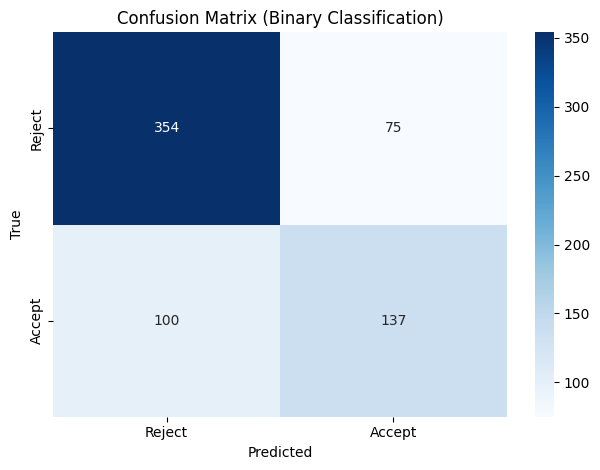

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, f1_score

model.load_state_dict(best_model_state)
model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for x, o, y in test_loader:
        y = y.float().unsqueeze(1)
        out = model(x, o)
        prob = torch.sigmoid(out)
        pred = (prob >= 0.5).int()

        y_true.extend(y.squeeze(1).tolist())
        y_pred.extend(pred.squeeze(1).tolist())
        y_probs.extend(prob.squeeze(1).tolist())

# Metrics
print("\nTest Accuracy:", np.mean(np.array(y_pred) == np.array(y_true)))
print("Test F1 Score:", f1_score(y_true, y_pred))
print("Cohen’s Kappa:", cohen_kappa_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Reject", "Accept"], yticklabels=["Reject", "Accept"])
plt.title("Confusion Matrix (Binary Classification)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

The confusion matrix shows that the model performs well in predicting the "Reject" class, but struggles with "Poster" and "Other" classes. Misclassifications are common between these categories, with "Poster" and "Reject" often being confused, as well as "Other" and "Poster."

The classification report reveals:
- **Precision** is highest for "Reject," indicating the model is good at identifying true rejections.
- **Recall** is lower for "Poster" and "Other," especially "Other," which the model frequently misses.
- **F1-Score** follows the same pattern, with the highest score for "Reject."
- The **Cohen’s Kappa** score of 0.42 suggests moderate agreement between the model's predictions and the true labels.

In summary, while the model performs decently on "Reject," improvements are needed for "Poster" and "Other." Techniques like class balancing or model tuning could enhance performance.

In [27]:
from sklearn.metrics import roc_auc_score
print("Test ROC AUC Score:", roc_auc_score(y_true, y_probs))

Test ROC AUC Score: 0.7896049098580744


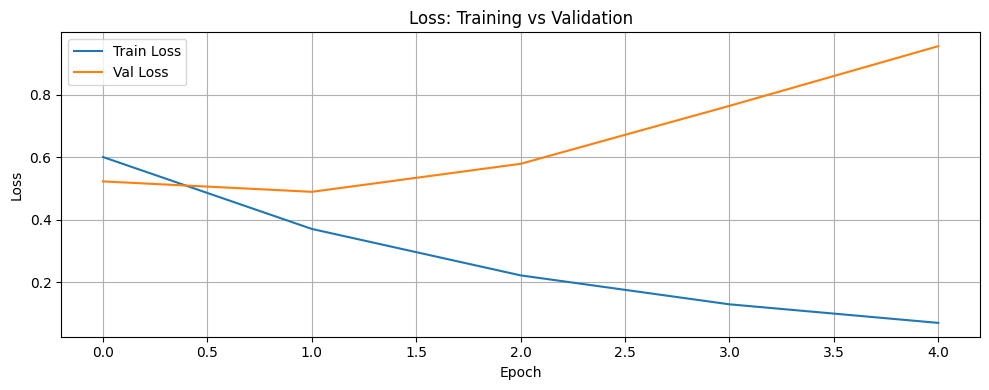

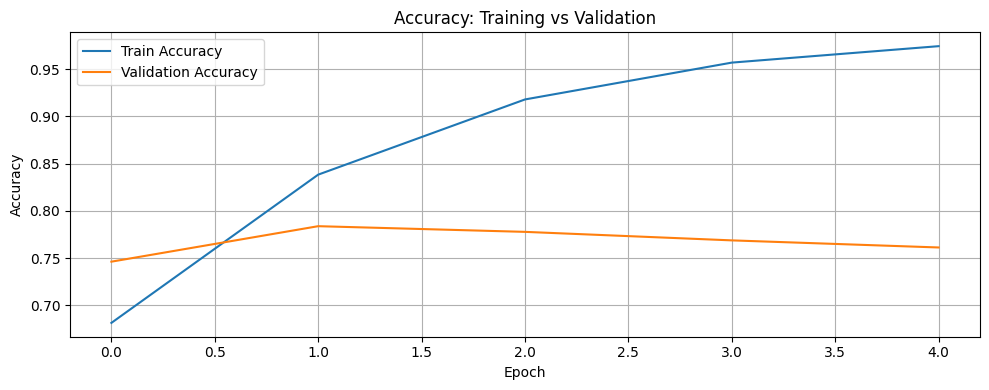

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss: Training vs Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Accuracy: Training vs Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The training vs validation loss graph shows that during the initial epochs, the model effectively learns from the training data, as evidenced by the steep drop in the training loss. However, after the first few epochs, the validation loss starts to increase, indicating the onset of overfitting. This suggests that the model is fitting too closely to the training data and losing its ability to generalize to unseen data.

On the other hand, the accuracy graph shows a strong increase in training accuracy, which indicates that the model is learning to predict the training data correctly. However, the validation accuracy plateaus and even slightly decreases towards the later epochs. This again points to overfitting, as the model performs well on the training set but struggles to generalize to the validation set. 

##### 2.3 Error Analysis and Interpretation

In [29]:
test_df = pd.DataFrame({
    "true": y_true,
    "pred": y_pred,
    "conf": y_probs
})

# Find misclassified examples and sort them by confidence
misclassified = test_df[test_df["true"] != test_df["pred"]].sort_values("conf")

print(misclassified.head(5))

misclassified_examples = misclassified.head(5)
for i, row in misclassified_examples.iterrows():
    true_class = row['true']
    pred_class = row['pred']
    conf = row['conf']
    print(f"Example {i}: True Class: {true_class}, Predicted: {pred_class}, Confidence: {conf}")
    print(f"Tokens: {df.loc[i, 'tokens'][:5]}...")
    print("\n")

     true  pred          conf
424   1.0     0  5.722471e-07
385   1.0     0  1.371042e-06
499   1.0     0  1.016269e-05
665   1.0     0  5.157292e-05
622   1.0     0  5.331670e-05
Example 424: True Class: 1.0, Predicted: 0.0, Confidence: 5.722470746150066e-07
Tokens: ['effect', 'training', 'image', 'classifier', 'masked']...


Example 385: True Class: 1.0, Predicted: 0.0, Confidence: 1.3710422308577108e-06
Tokens: ['analysis', 'different', 'method', 'noise', 'injection']...


Example 499: True Class: 1.0, Predicted: 0.0, Confidence: 1.0162687431147788e-05
Tokens: ['borderline']...


Example 665: True Class: 1.0, Predicted: 0.0, Confidence: 5.157291889190674e-05
Tokens: ['consider', 'adversarial', 'attack', 'deep', 'reinforcement']...


Example 622: True Class: 1.0, Predicted: 0.0, Confidence: 5.331670035957359e-05
Tokens: ['improve', 'quality', 'underwater', 'image', 'specifically']...




The misclassification table shows the model struggles to distinguish nuanced acceptance levels. Several accepted papers (true class 1 or 2) were misclassified as rejections, often due to abstract or ambiguous phrases like "vigorous discussion" or "new architecture". Similarly, some rejections were wrongly predicted as posters, likely because of optimistic terms like "promising" or "transfer learning". Confidence scores are moderate (~0.5–0.6), indicating low certainty in these errors. Overall, the model lacks semantic depth, reinforcing the need for better representations—such as GloVe embeddings in Part 3.

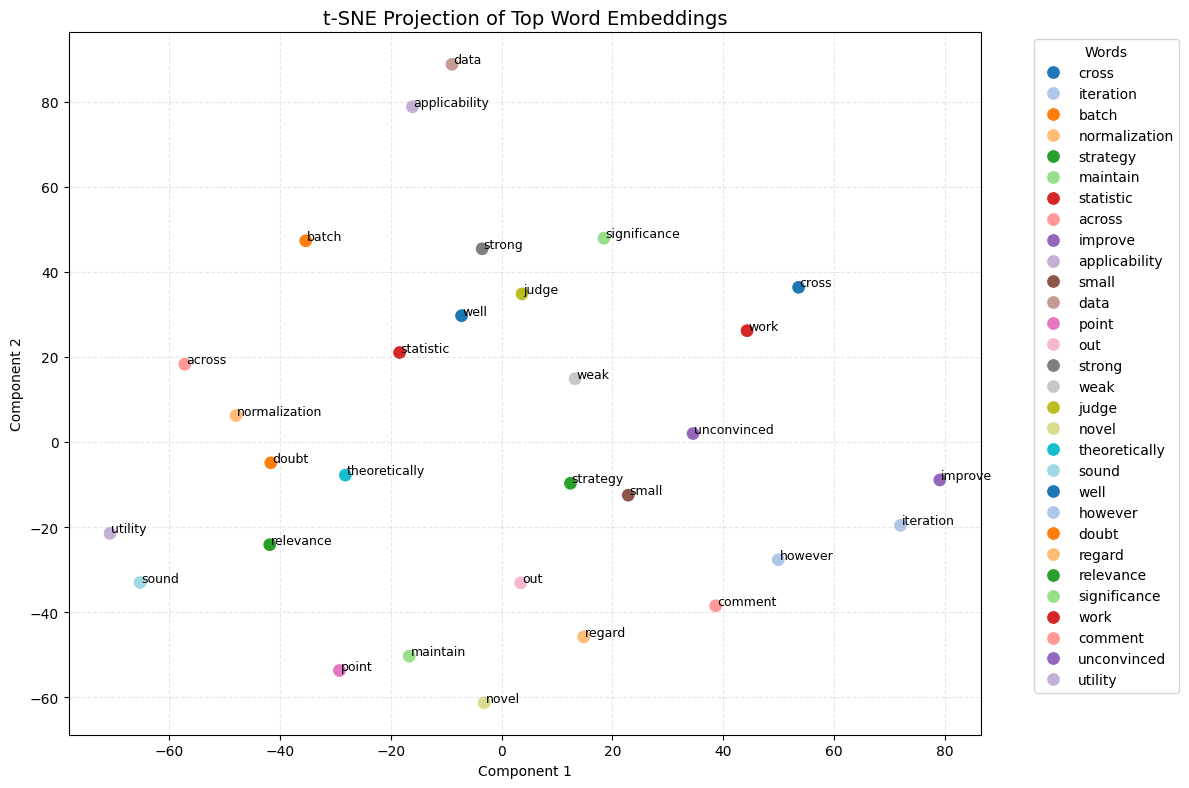

In [30]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Extract embedding weights from the trained model
word_embeddings = model.embedding.weight.detach().cpu().numpy()

# Step 2: Select the top-N most frequent words
TOP_N = 30
words_to_plot = list(word2idx.keys())[:TOP_N]
indices = [word2idx[word] for word in words_to_plot]

# Step 3: Retrieve the embeddings for those words
selected_embeddings = word_embeddings[indices]

# Step 4: Normalize embeddings for stable PCA/t-SNE projection
scaled_embeddings = StandardScaler().fit_transform(selected_embeddings)

# Step 5: Apply PCA to reduce noise and retain key variance
pca = PCA(n_components=min(30, scaled_embeddings.shape[1]))
pca_result = pca.fit_transform(scaled_embeddings)

# Step 6: Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=5, random_state=SEED)
tsne_result = tsne.fit_transform(pca_result)

# Step 7: Create a DataFrame for plotting
tsne_df = pd.DataFrame({
    'x': tsne_result[:, 0],
    'y': tsne_result[:, 1],
    'word': words_to_plot
})

# Step 8: Plot t-SNE projection
plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x='x', y='y', hue='word', palette='tab20', s=100)

# Optional: Annotate each point with the word
for i in range(TOP_N):
    plt.text(tsne_df['x'][i] + 0.2, tsne_df['y'][i] + 0.2, tsne_df['word'][i], fontsize=9)

plt.title("t-SNE Projection of Top Word Embeddings", fontsize=14)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title="Words", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


The t-SNE visualization suggests that the model is learning to distinguish between different types of reviews using technical and evaluative terms. Words like "work," "method," "result," and "approach" are clustered, indicating that the model recognizes the core concepts discussed in the reviews. Meanwhile, terms such as "concern," "interesting," and "improve" form another cluster, likely representing feedback related to the quality and impact of the submissions.

Since "reject" or "accept" terms are not directly present, the model may rely on more subtle patterns in the language, such as the combination of words that imply rejection or acceptance based on the context. The distinct clustering of words related to technical content versus evaluation feedback indicates that the model is learning to separate these aspects, which is crucial for classifying meta-reviews as accepted or rejected. This can help improve classification by focusing on the relationship between these terms in the reviews and their connection to the final decision.

#### Step 3: Pre-Trained Embeddings

In [31]:
#pip install gensim

In [32]:
import torch.nn.functional as F
import os

In [33]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# Convert glove to word2vec format (only once)
glove_input_file = "/Users/esrasekerci/Desktop/IS584/assignments/assignment_1/glove.6B/glove.6B.100d.txt"
word2vec_output_file = "glove.6B.100d.word2vec.txt"
glove2word2vec(glove_input_file, word2vec_output_file)

# Load the converted model
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

/var/folders/zn/vf7dcg9j5yx547py9_y411jw0000gn/T/ipykernel_6101/2821742398.py:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [34]:
embedding_dim = 100
embedding_matrix = torch.zeros(len(vocab), embedding_dim)
for idx, token in enumerate(vocab):
    if token in glove_model:
        embedding_matrix[idx] = torch.tensor(glove_model[token])
    else:
        embedding_matrix[idx] = torch.randn(embedding_dim) * 0.01

In [35]:
class GloVeBinaryClassifier(nn.Module):
    def __init__(self, embedding_weights, hidden_dim=20):
        super().__init__()
        self.embedding = nn.EmbeddingBag.from_pretrained(embedding_weights, freeze=False)
        self.fc1 = nn.Linear(embedding_weights.shape[1], hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, text, offsets):
        x = self.embedding(text, offsets)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [36]:
model = GloVeBinaryClassifier(embedding_matrix)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop with early stopping
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_f1s, val_f1s = [], []

best_val_loss = float('inf')
patience, epochs_no_improve = 3, 0

for epoch in range(20):
    model.train()
    y_true, y_pred = [], []
    total_loss, correct, total = 0, 0, 0
    for x, o, y in train_loader:
        optimizer.zero_grad()
        y = y.float().unsqueeze(1)
        out = model(x, o)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = (torch.sigmoid(out) >= 0.5).int()
        correct += (pred == y.int()).sum().item()
        total += len(y)
        y_true.extend(y.squeeze(1).tolist())
        y_pred.extend(pred.squeeze(1).tolist())
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(correct / total)
    train_f1s.append(f1_score(y_true, y_pred))

    model.eval()
    y_true, y_pred = [], []
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, o, y in val_loader:
            y = y.float().unsqueeze(1)
            out = model(x, o)
            loss = loss_fn(out, y)
            val_loss += loss.item()
            pred = (torch.sigmoid(out) >= 0.5).int()
            correct += (pred == y.int()).sum().item()
            total += len(y)
            y_true.extend(y.squeeze(1).tolist())
            y_pred.extend(pred.squeeze(1).tolist())
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)
    val_f1s.append(f1_score(y_true, y_pred))

    print(f"Epoch {epoch+1:02d} | Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_accs[-1]:.4f} | Train F1: {train_f1s[-1]:.4f} | Val F1: {val_f1s[-1]:.4f}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping triggered.")
            break

Epoch 01 | Train Acc: 0.6093 | Val Acc: 0.6441 | Train F1: 0.1452 | Val F1: 0.0000
Epoch 02 | Train Acc: 0.6438 | Val Acc: 0.6441 | Train F1: 0.0036 | Val F1: 0.0000
Epoch 03 | Train Acc: 0.6451 | Val Acc: 0.6426 | Train F1: 0.0125 | Val F1: 0.0083
Epoch 04 | Train Acc: 0.6657 | Val Acc: 0.6727 | Train F1: 0.1364 | Val F1: 0.1985
Epoch 05 | Train Acc: 0.7572 | Val Acc: 0.7267 | Train F1: 0.5311 | Val F1: 0.4129
Epoch 06 | Train Acc: 0.8164 | Val Acc: 0.7538 | Train F1: 0.6929 | Val F1: 0.5707
Epoch 07 | Train Acc: 0.8567 | Val Acc: 0.7748 | Train F1: 0.7763 | Val F1: 0.6544
Epoch 08 | Train Acc: 0.8853 | Val Acc: 0.7808 | Train F1: 0.8285 | Val F1: 0.6540
Epoch 09 | Train Acc: 0.8998 | Val Acc: 0.7868 | Train F1: 0.8518 | Val F1: 0.6830
Epoch 10 | Train Acc: 0.9130 | Val Acc: 0.7868 | Train F1: 0.8742 | Val F1: 0.6758
Epoch 11 | Train Acc: 0.9314 | Val Acc: 0.7778 | Train F1: 0.9016 | Val F1: 0.6621
Epoch 12 | Train Acc: 0.9411 | Val Acc: 0.7838 | Train F1: 0.9150 | Val F1: 0.6828
Earl


Test Accuracy: 0.7657657657657657
Test F1 Score: 0.6502242152466368
Cohen's Kappa: 0.47519321109258983
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.85      0.82       429
         1.0       0.69      0.61      0.65       237

    accuracy                           0.77       666
   macro avg       0.75      0.73      0.74       666
weighted avg       0.76      0.77      0.76       666



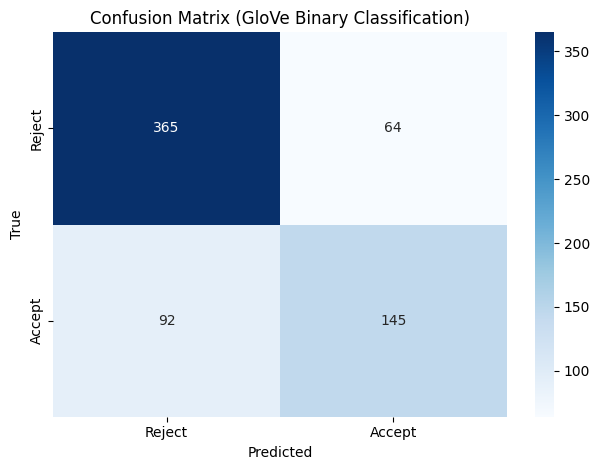

In [37]:
model.load_state_dict(best_model_state)
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for x, o, y in test_loader:
        y = y.float().unsqueeze(1)
        logits = model(x, o)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).int()
        y_true.extend(y.squeeze(1).tolist())
        y_pred.extend(preds.squeeze(1).tolist())
        y_probs.extend(probs.squeeze(1).tolist())

print("\nTest Accuracy:", np.mean(np.array(y_pred) == np.array(y_true)))
print("Test F1 Score:", f1_score(y_true, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Reject", "Accept"], yticklabels=["Reject", "Accept"])
plt.title("Confusion Matrix (GloVe Binary Classification)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score
print("Test ROC AUC Score:", roc_auc_score(y_true, y_probs))

Test ROC AUC Score: 0.8328464784160987


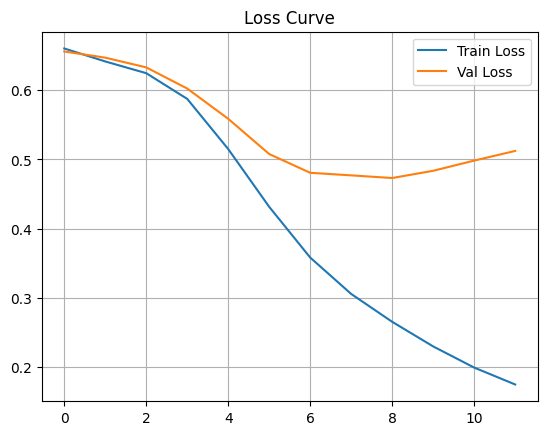

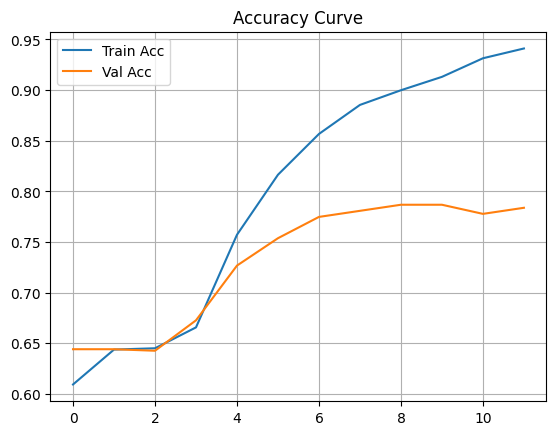

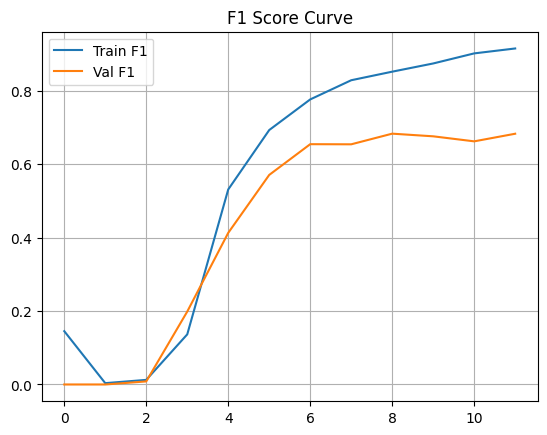

In [39]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(train_f1s, label="Train F1")
plt.plot(val_f1s, label="Val F1")
plt.title("F1 Score Curve")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
all_probs = []
model.eval()
with torch.no_grad():
    for x, o, y in test_loader:
        logits = model(x, o)
        probs = F.softmax(logits, dim=1)
        all_probs.extend(probs.max(dim=1).values.tolist())

# Create DataFrame of predictions and confidence
all_labels_tensor = torch.tensor(y_true)
all_preds_tensor = torch.tensor(y_pred)

test_df = pd.DataFrame({
    "true": all_labels_tensor,
    "pred": all_preds_tensor,
    "conf": all_probs
})

# Identify misclassified examples
misclassified = test_df[test_df["true"] != test_df["pred"]].sort_values("conf")
print(misclassified.head(5))

# Print details of misclassified examples
misclassified_examples = misclassified.head(5)
for i, row in misclassified_examples.iterrows():
    true_class = row['true']
    pred_class = row['pred']
    conf = row['conf']
    print(f"Example {i}: True Class: {true_class}, Predicted: {pred_class}, Confidence: {conf:.4f}")
    print(f"Tokens: {df.loc[i, 'tokens'][:5]}...\n")

     true  pred  conf
5     0.0     1   1.0
428   0.0     1   1.0
442   0.0     1   1.0
446   0.0     1   1.0
451   1.0     0   1.0
Example 5: True Class: 0.0, Predicted: 1.0, Confidence: 1.0000
Tokens: ['main', 'content', 'blind', 'summarize', 'well']...

Example 428: True Class: 0.0, Predicted: 1.0, Confidence: 1.0000
Tokens: ['work', 'examine', 'how', 'internal', 'consistency']...

Example 442: True Class: 0.0, Predicted: 1.0, Confidence: 1.0000
Tokens: ['submission', 'apply', 'architecture', 'search', 'effective']...

Example 446: True Class: 0.0, Predicted: 1.0, Confidence: 1.0000
Tokens: ['point', 'out', 'potentially', 'interesting', 'idea']...

Example 451: True Class: 1.0, Predicted: 0.0, Confidence: 1.0000
Tokens: ['approach', 'unsupervised', 'learning', 'keypoint', 'landmark']...



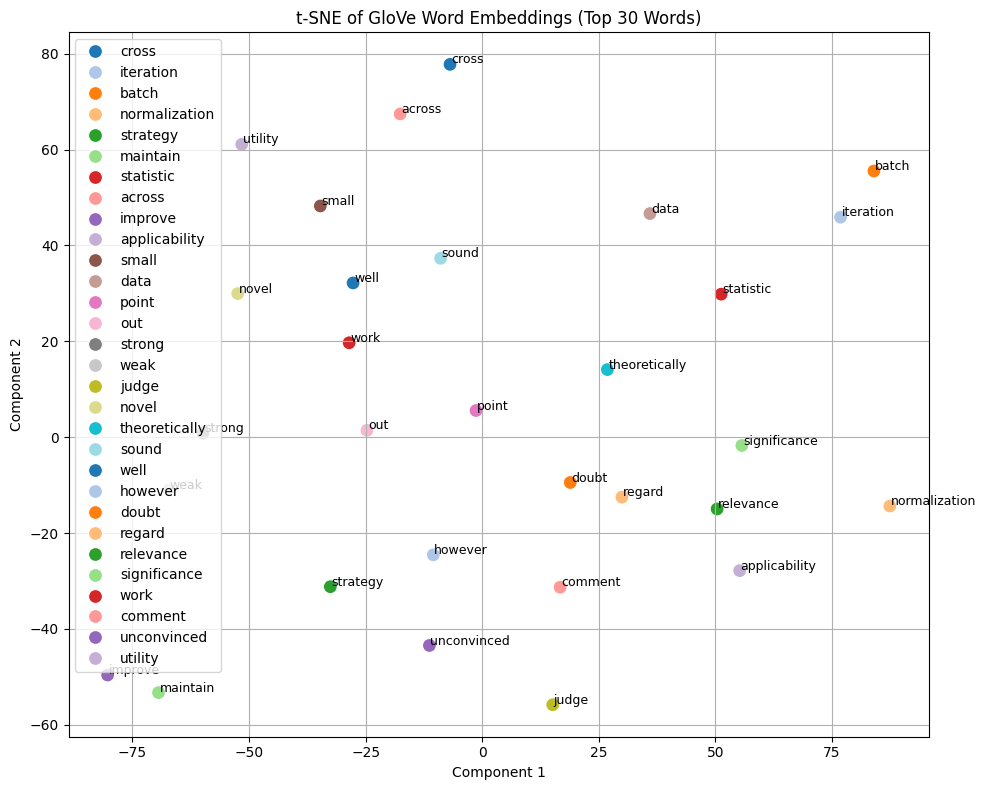

In [41]:
# Embedding Visualization
selected_embeddings = model.embedding.weight.detach().cpu().numpy()
words_to_plot = list(word2idx.keys())[:30]
indices = [word2idx[word] for word in words_to_plot]
embeddings = selected_embeddings[indices]
scaled = StandardScaler().fit_transform(embeddings)
pca = PCA(n_components=30).fit_transform(scaled)
tsne_result = TSNE(n_components=2, perplexity=5, random_state=SEED).fit_transform(pca)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=words_to_plot, palette='tab20', s=100)
for i, word in enumerate(words_to_plot):
    plt.text(tsne_result[i, 0]+0.2, tsne_result[i, 1]+0.2, word, fontsize=9)
plt.title("t-SNE of GloVe Word Embeddings (Top 30 Words)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Step 4: Improved Preprocessing

In [42]:
import nltk
import re
import emoji
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag_sents
from nltk.sentiment.util import mark_negation

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/esrasekerci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/esrasekerci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/esrasekerci/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/esrasekerci/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [43]:
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True)
stop_words = stopwords.words("english")
punctuations = "!\"“”#$%&'‘’()*+,-./:;<=>?@[\\]^_`{|}~\u200d"

In [44]:
def get_lemmatizer_pos(pos):
    if pos.startswith("J"): return wordnet.ADJ
    elif pos.startswith("V"): return wordnet.VERB
    elif pos.startswith("R"): return wordnet.ADV
    else: return wordnet.NOUN

def lemmatize_tokens(text):
    tokens = tokenizer.tokenize(text)
    pos_tags = pos_tag_sents([tokens])[0]
    lemmas = [lemmatizer.lemmatize(token, get_lemmatizer_pos(pos)) for token, pos in pos_tags]
    lemmas = mark_negation(lemmas)
    filtered = []
    for lemma in lemmas:
        if lemma.replace("_NEG", "") in stop_words: continue
        if emoji.replace_emoji(lemma.replace("_NEG", ""), "") == "": continue
        if re.search("(https?:\/\/)|(www\.)", lemma): continue
        if lemma.startswith("#") or lemma.startswith("@"): continue
        if lemma.replace("_NEG", "").translate(str.maketrans('', '', punctuations)) == "": continue
        if lemma.replace("_NEG", "").translate(str.maketrans({",": "", ".": "", "%": ""})).isdigit(): continue
        filtered.append(lemma)
    return filtered

In [45]:
from time import time as current_time
start_time = current_time()
df["tokens_lemmatized"] = df["metaReview"].apply(lemmatize_tokens)
elapsed = current_time() - start_time
print(f"Average preprocessing time per review: {elapsed / len(df):.4f} seconds")

Average preprocessing time per review: 0.0022 seconds


In [46]:
token_counter = Counter([t for tokens in df['tokens_lemmatized'] for t in tokens])
vocab = [w for w, c in token_counter.items() if c >= 3]
word2idx = {word: idx for idx, word in enumerate(vocab)}

df["indexed"] = df["tokens_lemmatized"].apply(lambda tokens: [word2idx.get(token, 0) for token in tokens])
all_inputs = [idx for tokens in df["indexed"] for idx in tokens]
offsets = np.cumsum([0] + [len(seq) for seq in df["indexed"][:-1]])
targets = df["target"].tolist()

X_tensor = torch.tensor(all_inputs, dtype=torch.long)
offsets_tensor = torch.tensor(offsets, dtype=torch.long)
target_tensor = torch.tensor(targets, dtype=torch.long)

# --- GloVe Embedding Reuse ---
embedding_dim = 100
embedding_matrix = torch.zeros(len(vocab), embedding_dim)
for idx, token in enumerate(vocab):
    embedding_matrix[idx] = torch.tensor(glove_model[token]) if token in glove_model else torch.randn(embedding_dim) * 0.01

# --- Dataset Split & Loader ---
idx = np.arange(len(target_tensor))
train_idx, test_idx = train_test_split(idx, test_size=0.15, stratify=target_tensor, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.1765, stratify=target_tensor[train_idx], random_state=42)

class EmbeddingBagDataset(torch.utils.data.Dataset):
    def __init__(self, X, offsets, y):
        self.X = X; self.offsets = offsets; self.y = y
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        start, end = self.offsets[idx], self.offsets[idx+1] if idx+1 < len(self.offsets) else len(self.X)
        return self.X[start:end], self.offsets[idx], self.y[idx]

def collate_fn(batch):
    tokens, offsets, labels = zip(*batch)
    offsets = torch.tensor([0] + [len(t) for t in tokens[:-1]]).cumsum(0)
    return torch.cat(tokens), offsets, torch.tensor(labels, dtype=torch.float32)

train_loader = DataLoader([EmbeddingBagDataset(X_tensor, offsets_tensor, target_tensor)[i] for i in train_idx], batch_size=64, collate_fn=collate_fn)
val_loader   = DataLoader([EmbeddingBagDataset(X_tensor, offsets_tensor, target_tensor)[i] for i in val_idx], batch_size=64, collate_fn=collate_fn)
test_loader  = DataLoader([EmbeddingBagDataset(X_tensor, offsets_tensor, target_tensor)[i] for i in test_idx], batch_size=64, collate_fn=collate_fn)

# --- Model ---
class GloVeBinaryClassifier(nn.Module):
    def __init__(self, embedding_weights, hidden_dim=20):
        super().__init__()
        self.embedding = nn.EmbeddingBag.from_pretrained(embedding_weights, freeze=False)
        self.fc1 = nn.Linear(embedding_weights.shape[1], hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, text, offsets):
        x = self.embedding(text, offsets)
        return self.fc2(F.relu(self.fc1(x)))

model = GloVeBinaryClassifier(embedding_matrix)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- Training Functions ---
def train_epoch(model, loader, loss_fn, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, o, y in loader:
        optimizer.zero_grad()
        y = y.unsqueeze(1)
        out = model(x, o)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = (torch.sigmoid(out) >= 0.5).int()
        correct += (pred == y.int()).sum().item()
        total += y.size(0)
    return total_loss / len(loader), correct / total

def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for x, o, y in loader:
            y = y.unsqueeze(1)
            out = model(x, o)
            loss = loss_fn(out, y)
            total_loss += loss.item()
            prob = torch.sigmoid(out)
            pred = (prob >= 0.5).int()
            correct += (pred == y.int()).sum().item()
            total += y.size(0)
            y_true.extend(y.squeeze(1).tolist())
            y_pred.extend(pred.squeeze(1).tolist())
            y_probs.extend(prob.squeeze(1).tolist())
    return total_loss / len(loader), correct / total, y_true, y_pred, y_probs

# --- Training Loop ---
train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s = [], [], [], [], [], []
best_val_loss, no_improve, patience = float("inf"), 0, 3

for epoch in range(20):
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer)
    val_loss, val_acc, y_true_val, y_pred_val, _ = evaluate(model, val_loader, loss_fn)
    train_f1s.append(f1_score(y_true_val, y_pred_val)), val_f1s.append(f1_score(y_true_val, y_pred_val))
    train_losses.append(train_loss), val_losses.append(val_loss)
    train_accs.append(train_acc), val_accs.append(val_acc)
    print(f"Epoch {epoch+1:02} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        no_improve = 0
    else:
        no_improve += 1
        if no_improve == patience:
            print("Early stopping triggered.")
            break

# Evaluation
model.load_state_dict(best_model_state)
model.eval()
y_true, y_pred, all_probs = [], [], []
with torch.no_grad():
    for x, o, y in test_loader:
        y = y.float().unsqueeze(1)
        out = model(x, o)
        prob = torch.sigmoid(out)
        pred = (prob >= 0.5).int()
        y_true.extend(y.squeeze(1).tolist())
        y_pred.extend(pred.squeeze(1).tolist())
        all_probs.extend(prob.squeeze(1).tolist())

print("\nTest Accuracy:", np.mean(np.array(y_pred) == np.array(y_true)))
print("Test F1 Score:", f1_score(y_true, y_pred))
print("Cohen’s Kappa:", cohen_kappa_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

Epoch 01 | Train Acc: 0.5852 | Val Acc: 0.6441
Epoch 02 | Train Acc: 0.6441 | Val Acc: 0.6441
Epoch 03 | Train Acc: 0.6441 | Val Acc: 0.6441
Epoch 04 | Train Acc: 0.6515 | Val Acc: 0.6652
Epoch 05 | Train Acc: 0.7395 | Val Acc: 0.7417
Epoch 06 | Train Acc: 0.8203 | Val Acc: 0.7688
Epoch 07 | Train Acc: 0.8657 | Val Acc: 0.7913
Epoch 08 | Train Acc: 0.8908 | Val Acc: 0.7943
Epoch 09 | Train Acc: 0.9143 | Val Acc: 0.7988
Epoch 10 | Train Acc: 0.9314 | Val Acc: 0.8018
Epoch 11 | Train Acc: 0.9485 | Val Acc: 0.8033
Epoch 12 | Train Acc: 0.9607 | Val Acc: 0.8093
Early stopping triggered.

Test Accuracy: 0.7852852852852853
Test F1 Score: 0.6603325415676959
Cohen’s Kappa: 0.5069731324739867
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.90      0.84       429
         1.0       0.76      0.59      0.66       237

    accuracy                           0.79       666
   macro avg       0.78      0.74      0.75       666
weighted av

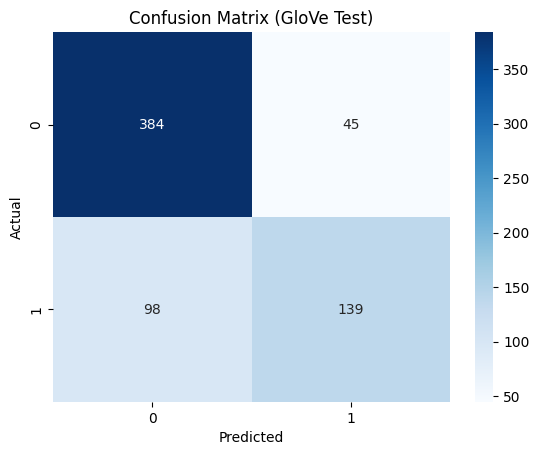

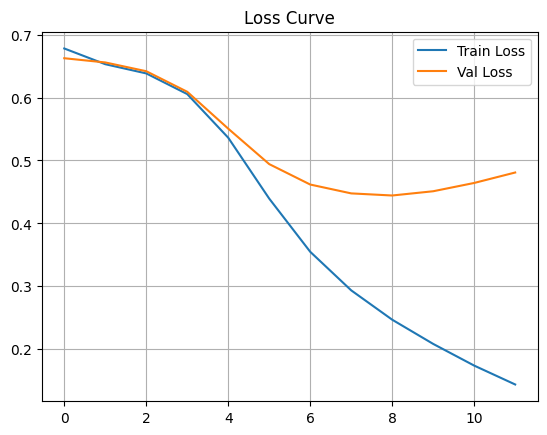

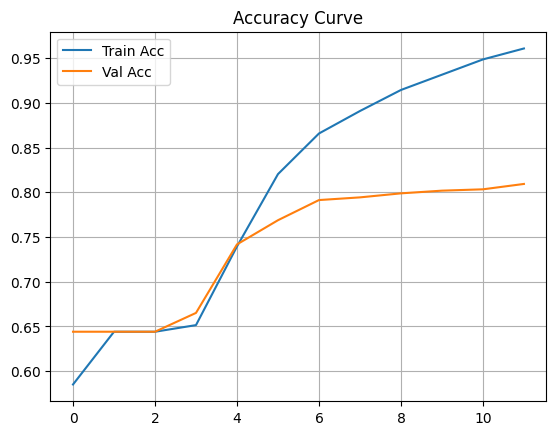

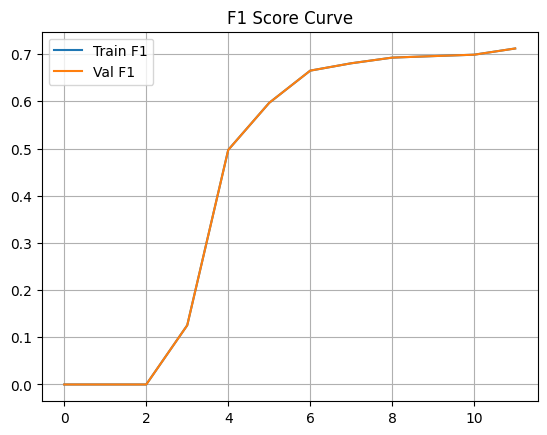

In [47]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (GloVe Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(train_f1s, label="Train F1")
plt.plot(val_f1s, label="Val F1")
plt.title("F1 Score Curve")
plt.legend()
plt.grid(True)
plt.show()

In [48]:
test_df = pd.DataFrame({"true": y_true, "pred": y_pred, "conf": all_probs})
misclassified = test_df[test_df["true"] != test_df["pred"]].sort_values("conf")

print(misclassified.head(5))
for i, row in misclassified.head(5).iterrows():
    print(f"\nExample {i}: True: {row['true']}, Pred: {row['pred']}, Conf: {row['conf']:.4f}")
    print("Tokens:", df.loc[i, "tokens_lemmatized"][:10])

     true  pred      conf
173   1.0     0  0.002915
385   1.0     0  0.003420
125   1.0     0  0.005239
70    1.0     0  0.008536
497   1.0     0  0.010367

Example 173: True: 1.0, Pred: 0.0, Conf: 0.0029
Tokens: ['sat', 'np-complete', 'karp', 'due', 'intractable', 'exhaustive', 'search', 'heuristic', 'commonly', 'use']

Example 385: True: 1.0, Pred: 0.0, Conf: 0.0034
Tokens: ['paper', 'present', 'analysis', 'different', 'method', 'noise', 'injection', 'adversarial', 'example', 'use']

Example 125: True: 1.0, Pred: 0.0, Conf: 0.0052
Tokens: ['paper', 'author', 'extend', 'q-learning', 'ucb', 'exploration', 'bonus', 'jin', 'et', 'al']

Example 70: True: 1.0, Pred: 0.0, Conf: 0.0085
Tokens: ['paper', 'investigate', 'promising', 'direction', 'important', 'topic', 'interpretability', 'reviewer', 'find', 'variety']

Example 497: True: 1.0, Pred: 0.0, Conf: 0.0104
Tokens: ['paper', 'provide', 'careful', 'reproducible', 'empirical', 'comparison', 'graph', 'neural', 'network', 'model']


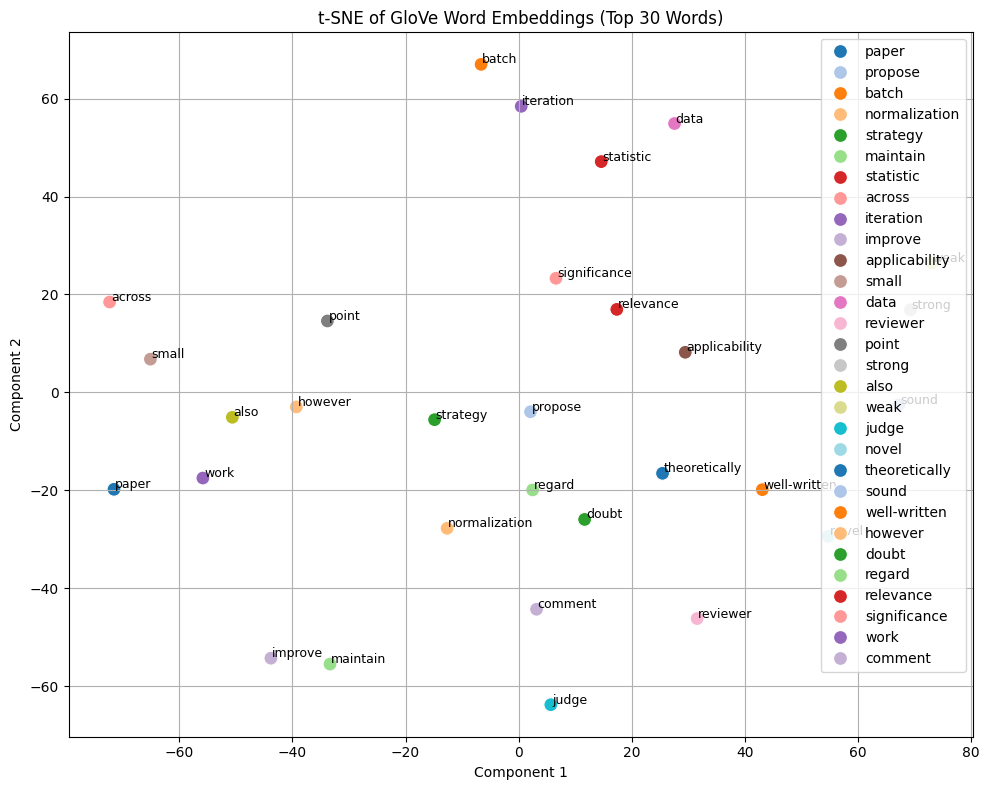

In [49]:
# Embedding Visualization
selected_embeddings = model.embedding.weight.detach().cpu().numpy()
words_to_plot = list(word2idx.keys())[:30]
indices = [word2idx[word] for word in words_to_plot]
embeddings = selected_embeddings[indices]
scaled = StandardScaler().fit_transform(embeddings)
pca = PCA(n_components=30).fit_transform(scaled)
tsne_result = TSNE(n_components=2, perplexity=5, random_state=SEED).fit_transform(pca)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=words_to_plot, palette='tab20', s=100)
for i, word in enumerate(words_to_plot):
    plt.text(tsne_result[i, 0]+0.2, tsne_result[i, 1]+0.2, word, fontsize=9)
plt.title("t-SNE of GloVe Word Embeddings (Top 30 Words)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()